# Lab book 
This playbook is a digital lab book to record experiments and keep track of
the progress: A collection of experiments results, notes and considerations

## XDP + custom driver (X-Lane) throughput-driven periodic peaks
> date: 5/2023 to 10/2023  
> files: fide-eval repository, data and playbooks: `xdp-xlane-comparison/`

Nodes with max isolation settings (as far as we could push it for now)
still show periodic peaks in long latency benchmarks. The period between
the peaks seems to be related to the sending interval (throughput) as it 
will be shown.

Tests have been run on different hardware and with different combination of
kernel bypass.

#### Data
`data` folder contains pingpong round trip timestamps. 
```
|SOC1|------------->|SOC2|
  ^                   ^
 ts1 (PING TX)       ts2 (PING RX)

|SOC1|<-------------|SOC2|
  ^                   ^
 ts4 (PONG RX)       ts3 (PONG TX)
```

All benchmark were  collected with max isolation settings. `xlane` uses a custom driver 
(optimistic timestamp) and core isolation. `xdp` uses a simple C client that sends UDP
packets in a loop and is pinned to an isolated core while XDP takes care of ts2,
(send back) ts3 and ts4, which should also run on isolated cores (smp affinity).
Both methods use UDP. Internal folder name indicate the sending interval.



### Relevant benchmark settings
- Software: X-Lane (custom driver), XDP + userspace
- Hardware:
    - Intel BigSpringCanyon SmartNIC, SOC CPU @ 1.5GHz, FPGA clock @ 300MHz.
    - standard intel Xeon servers, cpu @ 2.4 GHz
- Sending interval: 1ms
- isolcpus: yes
- timing interrupts shielded: yes
- no IRQ on isolated cores
- maxpower state
- logging type: kernel buffer
- number of rounds: 100k to 1M

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [10]:
cpu_freq = 2.4 * 1000000000  # 2.4 GHz

def peak_detection(data, thresh_us):
    avg = np.average(data)
    if thresh_us == -1:
        thresh_us = np.percentile(data, 99.9) - avg
    
    max_gap_to_combine_peaks = 500

    peaks = np.argwhere(abs(data) > avg + thresh_us)
    peaks_grouped = [[0,0]]
    for i in range(1,len(peaks)):
        peak = peaks[i][0]
        prev_peak = peaks_grouped[-1][-1] 
        if  peak-prev_peak <= max_gap_to_combine_peaks:
            peaks_grouped[-1][-1] = peak
        else:
            peaks_grouped.append([peak,peak])

    return peaks_grouped

def plot_jitter(folders, start = 0, end = -1, peak_threshold_us = -1):
    clock_to_us = 1000000 / cpu_freq
    num_of_plots = len(folders)
    #init figure
    fig, axs = plt.subplots(num_of_plots, 1, layout = "constrained")

    for i in range(num_of_plots):
        data = pd.read_csv(folders[i]+'/out.txt', sep=',', header=None, engine='python', skiprows=10, skipfooter=1) * clock_to_us
        ping_tx_diff = np.ediff1d(data[1][start:end]) # diff of consecutive elems
        ping_rx_diff = np.ediff1d(data[2][start:end])
        pong_tx_diff = np.ediff1d(data[3][start:end])
        pong_rx_diff = np.ediff1d(data[4][start:end])

        x = np.arange(0,len(pong_rx_diff),1)
        if (num_of_plots == 1):
            ax = axs
        else:
            ax = axs[i]

        # plot overall jitter from the round trip
        ax.scatter(x, pong_rx_diff, s = 1)

        # detect and plot peaks for individual timestamps
        pong_rx_peaks = peak_detection(pong_rx_diff-pong_tx_diff, peak_threshold_us)
        for s,e in pong_rx_peaks:
            ax.axvspan(s, e, color='blue', alpha=0.5, label="pong rx")
        
        pong_tx_peaks = peak_detection(pong_tx_diff - ping_rx_diff, peak_threshold_us)
        for s,e in pong_tx_peaks:
            ax.axvspan(s, e, color='orange',alpha=0.5, label="pong tx")

        ping_rx_peaks = peak_detection(ping_rx_diff-ping_tx_diff, peak_threshold_us)
        for s,e in ping_rx_peaks:
            ax.axvspan(s, e, color='green', alpha=0.5, label="ping rx")

        ping_tx_peaks = peak_detection(ping_tx_diff, peak_threshold_us) 
        for s,e in ping_tx_peaks:
            ax.axvspan(s, e, color='red', alpha=0.5, label="ping tx")

        # filter labels for legend: TOO SLOW
        # filtered_labels = [[],[]]
        # handlers,labels = ax.get_legend_handles_labels()
        # i = 0
        # for l in labels:
        #     if (l not in filtered_labels[1]):
        #         filtered_labels[0].append(handlers[i])
        #         filtered_labels[1].append(l)
        #     i += 1
            
        # ax.legend(filtered_labels[0],filtered_labels[1])
        # Compute and print distance between peaks
        print(f'PING TX peak distance (red): {np.ediff1d(np.array(ping_tx_peaks)[:,1])}')
        print(f'PING RX peak distance (green): {np.ediff1d(np.array(ping_rx_peaks)[:,1])}')
        print(f'PONG TX peak distance (orange): {np.ediff1d(np.array(pong_tx_peaks)[:,1])}')
        print(f'PONG RX peak distance (blue): {np.ediff1d(np.array(pong_rx_peaks)[:,1])}')

#### X-Lane jitter at decreasing sending interval
The following cell shows the performance of X-Lane at 1ms, 500us, 250us and 100us.  
The plotter functions outputs the difference of consecutive ts4, which contains 
all jitter accumulated in the round trip. It then detects jitter peaks introduced by every
single communication interval (i.e. ts1-ts2,ts2-ts3,ts3-ts4), in order to check
whether the jitter was introduced at TX vs RX. It also outputs the number of rounds
between each peak. The threshold determining peaks is defined as an argument of the plotter.

PING TX peak distance (red): [64201]
PING RX peak distance (green): [ 4610 18750  1653 20527 20403 20419]
PONG TX peak distance (orange): [ 4578 13479  6920  8104 12419  2595 17828 12176  8303  6688]
PONG RX peak distance (blue): [ 2773  1745 18622 20395 20419  1901  4319 14035]
PING TX peak distance (red): []
PING RX peak distance (green): [ 8470 10639 10679 10647 10615 10679 10662 10615 10655]
PONG TX peak distance (orange): [ 8542 10535  3384  7279 10655 10887  1113  9382 10565 10081   655   648
  9911]
PONG RX peak distance (blue): [ 1854 10599 10551 10551 10511 10518 10496  7223  3271 10455 10510]
PING TX peak distance (red): []
PING RX peak distance (green): [2081 5407 5471 5455 5422 5424 2837 2570 5391 5439 5375 5391 1813 3578
 5327 5423 1237 9609  821 4586 5439 5439]
PONG TX peak distance (orange): [ 2049  5407  5487  5423  5423  5423  5423  5391  5423  5407  5359  5391
  5327  5439  5663 10558  5471  5407]
PONG RX peak distance (blue): [ 5183 10510  5247  5231  5231  2826  235

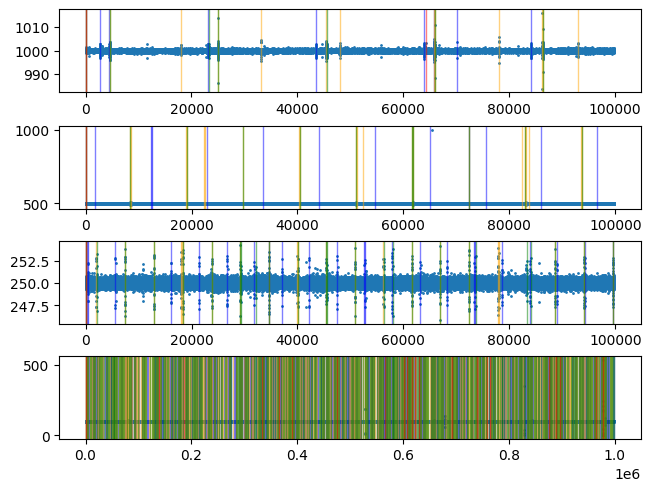

In [8]:
bf = "data/xlane"
folders = [f"{bf}/1ms", f"{bf}/500us", f"{bf}/250us", f"{bf}/100us", ]
plot_jitter(folders,start=100, peak_threshold_us=2)

#### XDP + userspace send jitter at decreasing sending interval
As above but for XDP data.

PING TX peak distance (red): []
PING RX peak distance (green): [12451 15951 15902 15951 15956 15971]
PONG TX peak distance (orange): [28378 31850 15963 15967]
PONG RX peak distance (blue): [15764 16067 16027  8483  7584  7388  8747 16126]
PING TX peak distance (red): []
PING RX peak distance (green): [  929  3038  3237  4678  3238  3238  1599  3238  3238  3238  1599  3238
  1599  3238  3198  4797  3198  1599  9594  3158  1599  6396  3158 14390
  1600  6396  1599  3198  1639  3198  1599  1599  3198  1599  1599  1598
  1600  1599  1599  3198  1599  4837  4797  9674  1599  3198  4837  1639
  3198  1599  3238  1599 11273  3238  1599  3198  1639  1599  1639  4797
  1599  3238  4837  9634  3198  4797  3198  7995 12832  1598 11274  3238
  1599  4836  4838  1599  1599  1599  3198  1638  1600  4837  4837  3158
  6436  4837  4837  1559  3238  1599  1599  9553  1600  1599  9634  3238
  1598  4838  3238  3198  1599  8035  3198  9634  8035  3198 17629  3238
  3238  1639  1598  3239  1598  1600  647

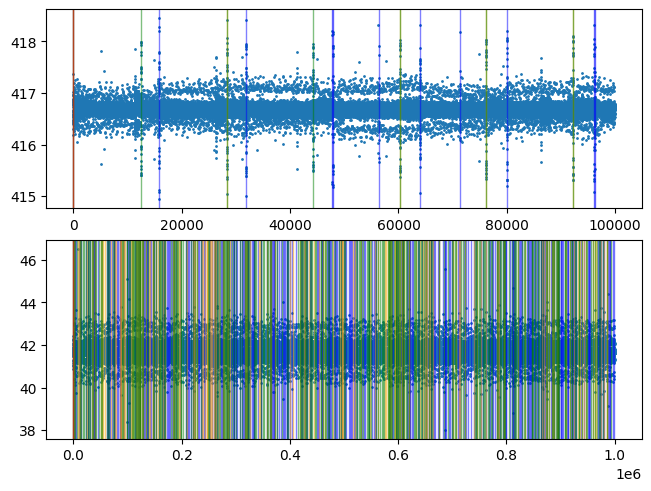

In [15]:
bf = "data/xdp-usr-isol"
folders = [f"{bf}/1ms", f"{bf}/100us", ]
plot_jitter(folders,start=100, peak_threshold_us=1.2)

#### XDP + LKM send loop jitter at decreasing sending interval
As above.

PING TX peak distance (red): [63503]
PING RX peak distance (green): [ 1968 20723 20887 20823 20819]
PONG TX peak distance (orange): [ 1936 41610 20827 20815]
PONG RX peak distance (blue): [21518 20863 20943 20815]
PING TX peak distance (red): []
PING RX peak distance (green): []
PONG TX peak distance (orange): [ 2970 10956  2718  5319 13555  2639  5437 16275  8157 10916 10796 10756
 13555  5438 24430 51622  5398  8116  2680  5398  5478  2719 13595  5397
 13515  8198 18913  2758  2719  5518  5399  2719  2719  8117 10916  2679
  5478  8077  2639  5438 10796  2718  8118  2719  5437  2719 10796  2719
 10877 19073  5438  5397 40706  5438 10835 13556 27109  2640 24390 10797
 10916  2719 32588 10836 21712 10916  2719 30069  5358 51780  2759  8158
  8156  8237  8158 10876 10836 13515 16313  8197 37987 16274 29909  8077
  2759 29949 13515 16234  8116  5479  5438 32707  5478  8118 19073 10876
 10795 10917 32748 10836  8157 16274 21832  5477  5478 18873 16195  2639
 10836  2639 16274  2679  5438 

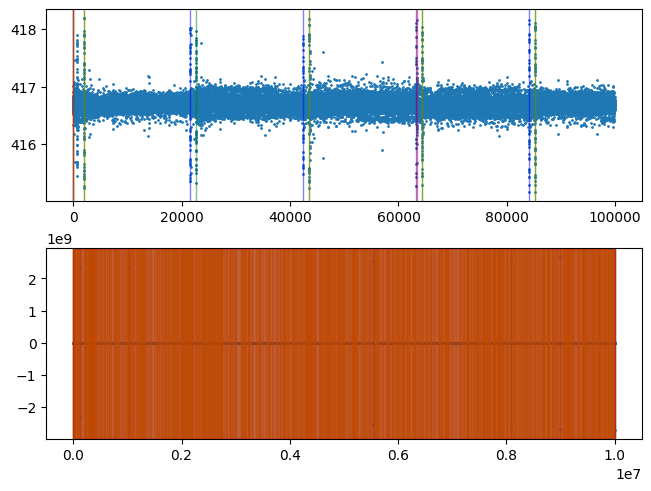

In [16]:
bf = "data/xdp-lkm"
folders = [f"{bf}/1ms", f"{bf}/100us", ]
plot_jitter(folders,start=100, peak_threshold_us=1.2)

### Results
#### TX vs RX path
PING RX (green) and PONG RX (blue) show the most frequent and higher jitter peaks.
This could be an indication that the RX path is more affected by jitter. Moreover,
the peaks in each these 2 paths are correlated through some periodicity. PONG TX
patch shows a smaller number of jitter peaks but these are ofter coupled with green
peaks, hence most likely "inherited"/jitter accumulated from PING RX. Plus they do 
not show clear periodicity.

#### Jitter peaks frequency
Benchmarks for both X-Lane and XDP show periodic jitter peaks in RX paths which
have clear correlation the sending interval.
```
XLANE
send_period | avg peak-to-peak # of packets     
1ms         | ~20k
500us       | ~10.5k
250us       | ~5.4k
100us       | dense

XDP USR
send_period | avg peak-to-peak # of packets     
1ms         | ~16k
100us       | dense

XDP LKM
send_period | avg peak-to-peak # of packets     
1ms         | ~20.8k
100us       | dense
```
The possible cause of these peaks is unknown up to now!

Peaks become very dense that they are noticeable anymore at 100us, it seems because 
they become very close to each other that it is impossible to distinguish. 

#### Notes
- XDP smaller peak magnitude and less or no outliers
  than X-Lane.
- XDP user has smaller peak-to-peak interval compared to the other 2. The difference might be due to different systems settings? the fact that we use the kernel?
- All results shown are from standard servers with Intel Xeon. Benchmarks on the
SoC show similar results (see peaks in later experiments). Longer benchmakr are required
on other hardware to analyse periodicity.

#### Zoomed in peak
If we zoom into a peak it looks like the image below. 
We can see a strange 1 high - 3 low pattern, whose regularity
might be insightful and related to the problem.

![zoom peak](plots/peak_zoomed_in.png)

## X-Lane (custom bypass) jitter locality on FPGA SmartNIC 
> tests ran in date: 06/2023 and 07/2023\
> files: fide-eval repository, playbook bsc-fpga/fullts/*.ipynb, data: bsc-fpga/fullts/kbuf-logtype

This benchmark uses a FPGA SmartNIC with FPGA timestamp functionality to
breakdown the communication latency of the TX and RX path. The setup is a
2 nodes connected with a p2p connection, no switch in between.

```
|SOC1|--->|FPGA1|------->|FPGA2|--->|SOC2|
  ^          ^              ^         ^
 ts1        ts2            ts3       ts4
```
Timestamps ts2 and ts3 are taken respectively after and before the PCIe bus. 
ts1 is taken in the software send loop of the LKM. ts4 is an *optimistical
timestamp*, taken as early as possible in a customised net driver (X-Lane
Linux). It's worth noting that there might be additional non -negligible delay
from ts4 to an application. 

No clock is sync'd (SOC-SOC nor SOC-FPGA), so we obtain the jitter through the difference
of successive timestamps. For ts1: `ts1(n+1)-ts1(n), ts1(n+2)-ts1(n+1)...`, same for ts2, 
ts3 and ts4. Differences when comparing the plots allow us to detect whether the jitter occurred
in the TX path, network, or RX path.

### Relevant benchmark settings
- Software: X-Lane
    - custom mlx5 driver with ts
    - pacemaker loop in LKM pinned to dedicated core
- Hardware: Intel BigSpringCanyon SmartNIC, SOC CPU @ 1.5GHz, FPGA clock @ 300MHz.
- Sending interval: 1ms
- isolcpus: yes
- timing interrupts shielded: yes
- no IRQ on isolated cores
- maxpower state
- logging type: kernel buffer
- number of rounds: 20000


![comparison plot](plots/soc_fpga_comparison_20230705_1732.png)
![comparison plot](plots/soc_fpga_comparison_20230726_1425.png)
<!-- ![comparison plot](plots/soc_fpga_comparison_20230727_1732.png) -->


### Results
The first 4 plots show SoC and FPGA timestamps (ordered ts1 to ts4 top
to bottom), the bottom plot shows the one trip latency estimation calculated
with the usual pingpong formula:
```
[(pong_rx_ts - ping_tx_ts) - (pong_tx_ts - ping_tx_ts)]/2
```
We can see that we have spikes at both in both sending and receiving.
The sending spikes are caused before taking the timestamps, in other words
the TX path from ts1 to ts2 seem to not introduce delays, since the
at SoC peaks correspond FPGA peaks. Blue dots behind the orange ones in the 
new spikes in ping send and PONG send are barely visible but they were verified.

On the receiving side the spikes occurs in the RX path, between ts3 and ts4, as it
can be seen since the spikes occur in the SoC and not in the FPGA for recv timestamps.
The pingpong latency formula only reports the recv peaks, hinting that it might be 
an inaccurate metric.

### Considerations
In conclusion, the TX spikes seem to be caused by a delay in the scheduling (i.e. 
before ts1) of the send, while the RX spikes are caused between ts3 and ts4. The causes
of the latter could be PCIe or OS jitter. Since the TX to RX spikes are very similar
in terms of periodicity and magnitude, I suspect the the cause is OS for both.

It needs to be considered that these periodic spikes and only visible at "slow"
sending intervals (>100us), at faster intervals we suppose that they become so dense
that it is impossible to distinguish them. Also, the magnitude is small compared to other
larger, more problematic spikes that often occur during long runs.

## XDP usr vs XDP lkm vs X-Lane
This is a microbenchmark to compare the per-packet latency of 3 different approaches.
We measure latency using a packet ping pong between 2 servers A and B using the formula:

```
latency = ( (PONG_RECV_A - PING_SEND_A) - (PING_RECV_B - PONG_SEND_B))/2
```
We compare:

- XDP userspace/unpriviledged (kernel-bypass): this approach is subject to jitter
- X-Lane: endhosts and network are dedicated and isolated 
- X-Lane and XDP combined (FiDe)

![](plots/setup_diagram.png) 

Here we only focus on sending interval < 100us where peaks are compressed and not visible.
See above for larger interval and peak analysis. 

### Relevant benchmark settings
- Hardware standard intel Xeon servers, cpu @ 2.4 GHz
- Sending interval: 1ms
- max isolatation setting (see above) and **no isolation**
  for XDP usr
